In [2]:
using FITSIO, PyPlot, Interpolations, Optim, ForwardDiff

# load 3D grid

In [3]:
grid = FITS(read ∘ first, "grid_files/am03cm10np05vp12.fits");
wls = (10 .^ range(log10(15100.802); step=6e-6, length=size(grid, 1)))

@assert all(isnan.(grid), dims=[2, 3, 4]) == any(isnan.(grid), dims=[2, 3, 4])
mask = .! any(isnan.(grid), dims=[2, 3, 4])[:]

grid = grid[mask, :, :, :];
wls = wls[mask]
;

In [4]:
param_names = ["teff", "logg", "metallicity"]
llimits = [3500., 0., -2.5]
steps   = [250, 0.5, 0.25]
ulimits = [6250, 5.0, 1.25]
ranges = (:).(llimits, steps, ulimits .- steps)

3-element Array{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},1}:
 3500.0:250.0:6000.0
 0.0:0.5:4.5
 -2.5:0.25:1.0

-----
# Interpolation

## Naive multi-interpolation (separate interpolator for each pixel)
how to make this more efficient? https://github.com/JuliaMath/Interpolations.jl/issues/389

In [5]:
itps = [CubicSplineInterpolation(tuple(ranges...), grid[i, :, :, :]) for i in 1:size(grid, 1)];
interpolate_spectrum(x) = [itp(x...) for itp in itps]
function interpolated_jacobi(x)
    J = Matrix(undef, size(grid, 1), length(x))
    for (λ, itp) in enumerate(itps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end

interpolated_jacobi (generic function with 1 method)

  1.360167 seconds (9.77 M allocations: 325.765 MiB, 4.33% gc time)
  

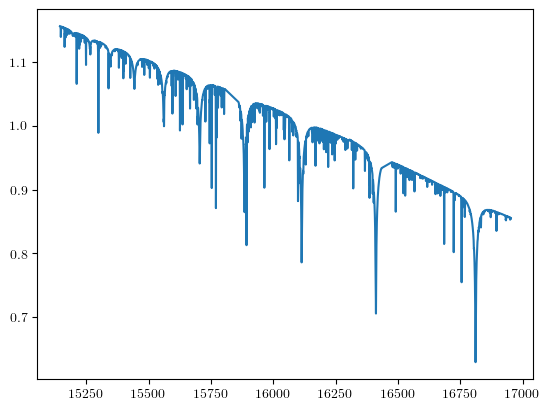

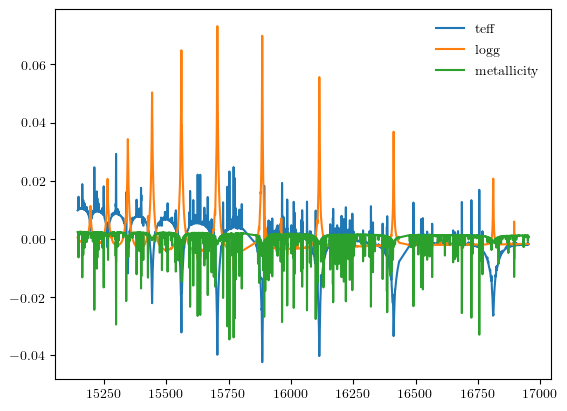

1.552514 seconds (6.72 M allocations: 249.730 MiB, 1.86% gc time)


In [6]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, @time interpolate_spectrum(x))

figure()
lines = plot(wls, (@time interpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

# Naive multi-interpolations with reflecting boundary conditions

In [12]:
ritps = [scale(interpolate(grid[i, :, :, :], BSpline(Cubic(Reflect(OnGrid())))), ranges...) for i in 1:size(grid, 1)]
rinterpolate_spectrum(x) = [itp(x...) for itp in ritps]
function rinterpolated_jacobi(x)
    J = Matrix(undef, size(grid, 1), length(x))
    for (λ, itp) in enumerate(ritps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end
function rinterpolated_hessian(x)
    H = Matrix(undef, size(grid, 1), length(x), length(x))
    for (λ, itp) in enumerate(ritps)
        Interpolations.hessian!(view(H,λ,:,:), itp, x...)
    end
    H
end

rinterpolated_hessian (generic function with 1 method)

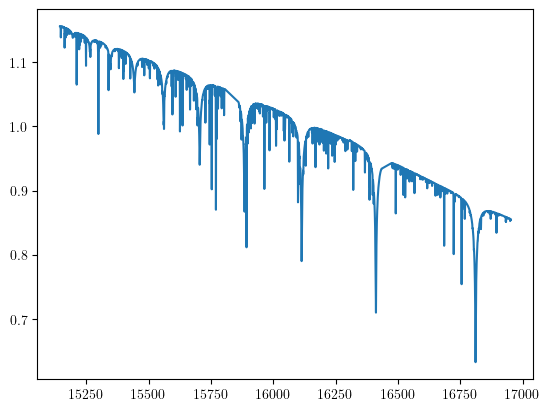

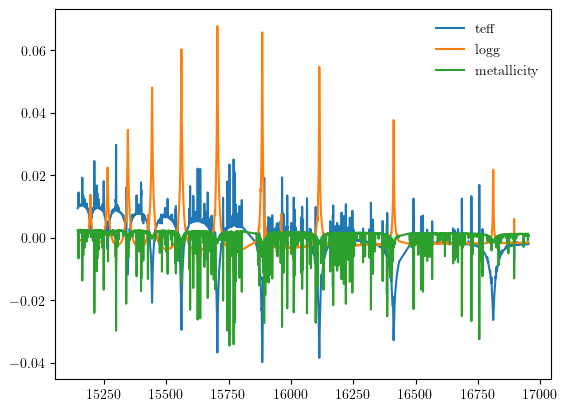

  0.046742 seconds (127.81 k allocations: 5.466 MiB)
  0.015898 seconds (110.97 k allocations: 3.532 MiB)


In [13]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, @time rinterpolate_spectrum(x))

figure()
lines = plot(wls, (@time rinterpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

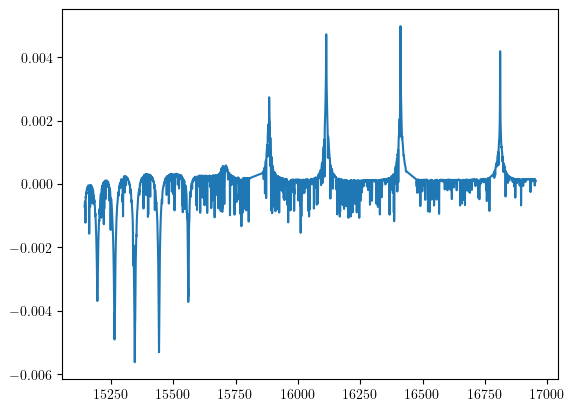

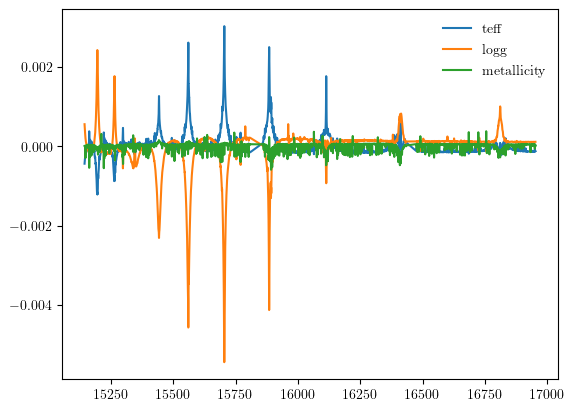

In [14]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, rinterpolate_spectrum(x) - interpolate_spectrum(x))

figure()
lines = plot(wls, (rinterpolated_jacobi(x) - interpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

# multithreading

In [7]:
Threads.nthreads()

4

In [34]:
rand_params() = rand(3) .* (ulimits - llimits - steps) + llimits
function perturb_and_interp(x)
    x += randn(3) .* steps * 0.1
    interpolate_spectrum(x)
end

x = rand_params()
N = 100
@time begin
    a = Vector{Vector{Float64}}(undef, N)
    for i in 1:N
        a[i] = perturb_and_interp(x)
    end
end
@time begin
    a = Vector{Vector{Float64}}(undef, N)
    Threads.@threads for i in 1:N
        a[i] = perturb_and_interp(x)
    end
end
;

  0.562247 seconds (3.89 M allocations: 65.537 MiB)
  0.259081 seconds (3.90 M allocations: 66.477 MiB, 12.07% gc time)


------


# inference - now with derivatives

note: `Interpolations.hessian` causes a stack overflow.  I think the problem has something to do with boundary conditions?
https://github.com/JuliaMath/Interpolations.jl/issues/364,  https://github.com/JuliaMath/Interpolations.jl/issues/268

In [ ]:
#demo - this doesn't work
Interpolations.hessian(ritps[20], [5512, 2.44, 0.113])
function χ2hessian!(H, params)
    J = rinterpolated_jacobi(params)
    res = (rinterpolate_spectrum(params) .- f)
    H = map(1:size(grid, 1)) do λ
        Hλ = Interpolations.hessian!(ritps[λ], params)
        2/err[λ]^2 * (J[λ]*J[λ]' + res[λ] * Hλ)
    end |> sum
end

In [1]:
f = interpolate_spectrum([5112.23, 3.34, 0.112])
err = ones(size(f)) * 0.01
f .+= randn(size(f)) .* err

χ2(params) = sum(((interpolate_spectrum(params) .- f) ./ err).^2)
χ2grad(params) = sum( 2 * (interpolate_spectrum(params) .- f) .* interpolated_jacobi(params) ./ err.^2, dims=1)[:]
χ2grad!(G, params) = G .= χ2grad(params)
χ2hessian!(H, params) = ForwardDiff.hessian!(H, χ2, params)

println("no gradient")
@time res = optimize(χ2, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)

println()
println("analytic gradient")
@time res = optimize(χ2, χ2grad!, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)

println()
println("analytic gradient and autodiff hessian")
@time res = optimize(χ2, χ2grad!, χ2hessian!, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)
res

LoadError: UndefVarError: interpolate_spectrum not defined

---

# unsuccesful approaches to interpolation

## multi-interpolation with a custom type is slow

In [7]:
struct NVec{F, N}
    data :: Vector{F}
end

Base.:+(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .+ y.data)
Base.:-(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .- y.data)

Base.:*(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .* y.data)
Base.:*(x::Real, y::NVec{F, N}) where F where N = NVec{F, N}(x .* y.data)
Base.:*(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data .* y)

Base.:/(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data ./ y)

Base.zero(::Type{NVec{F, N}}) where F where N = NVec{F, N}(zeros(F, N))

In [8]:
param_inds = CartesianIndices(size(grid)[2:end])
g = [NVec{Float32, size(grid, 1)}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g);

In [17]:
@time interpolated_jacobi(x);
@time Interpolations.gradient(itp, x...)
;

  0.006607 seconds (115.79 k allocations: 3.246 MiB)
  0.012699 seconds (1.40 k allocations: 28.294 MiB)


It's slower :(  Perhaps if I could figure out how to tell the compiler that the grid is static get it all into one memory block...

## multi-interpolation with StaticArrays - compile time is prohibitive

don't execute this cell unless you want to watch your computer compile forever

In [ ]:
using StaticArrays
g = [SVector{size(grid, 1), Float32}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g)